In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [7]:
import ast
import string
from subprocess import check_output
import gensim
from gensim import corpora
import re

import warnings
import librosa
from scipy import stats

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image

import seaborn as sn
% matplotlib inline

In [6]:
import plotly.plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# The Best File

## Part A: Cleaning and Statistics of the Database

### Cleaning and Merging Datasets

In [8]:
tracks = pd.read_csv('~/Documents/fma_metadata/tracks.csv')#this is the database containing the description of each tracks
features = pd.read_csv('~/Documents/fma_metadata/features.csv')#this is the database containing the features of each tracks
genres=pd.read_csv('~/Documents/fma_metadata/genres.csv')

/Users/danielgomez/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/danielgomez/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186

In [9]:
tracks['Unnamed: 0'].iloc[0] = tracks['Unnamed: 0'].iloc[1]

tracks.columns = [col[0:5] + '_' + tracks[col][0] for col in tracks.columns]
tracks.columns.values[0] = 'track_id'

tracks = tracks[2:]
tracks = tracks.reset_index(drop=True)

keep_variables = ['track_id','track_title','track_genre_top','track_genres','track_genres_all']
tracks = tracks[keep_variables]

In [10]:
features.columns = [col+ '_' + features[col][0] for col in features.columns]
features.columns.values[0] = 'track_id'

features = features[3:]
features = features.reset_index(drop=True)

In [11]:
df_final = pd.merge(tracks, features, on='track_id', how='inner')
cols = [col for col in df_final.columns.values if 'chroma' not in col]
df_final = df_final[cols]
#df_final.to_csv('df_final.csv',index=False)

### Descriptive Statistics

In [ ]:
len(df_final)

In [ ]:
len(df_final.columns)

In [10]:
G = nx.DiGraph()
#Function that inputs the id of the genre and outputs the title of the genre
def get_title(genreid,genres=genres):
    return(genres.title[genres.genre_id==genreid].unique()[0])
#Function that inputs the title of the genre and outputs the id of the genre
def get_id(genretitle,genres=genres):
    return(genres.genre_id[genres.title==genretitle].unique()[0])
#Function that inputs the title of a genre and outputs the subgenres of the genre
def get_subgenres(genretitle,G=G):
    return([edge[1] for edge in G.edges(genretitle)])

In [11]:
G.add_node("Genres")
parents=genres.genre_id[genres.parent==0].unique()
for parent in parents:
    G.add_edge("Genres",get_title(parent))
while  not parents==[]:
    all_children=[]
    for parent in parents:
        children=genres.genre_id[genres.parent==parent].unique()
        all_children.extend(children)
        for child in children:
            G.add_edge(get_title(parent),get_title(child))
    parents=all_children
p=nx.drawing.nx_pydot.to_pydot(G)
p.write_png('Tree_genres.png')

/home/marianne/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


True

In [ ]:
len(G.nodes())

In [ ]:
count=df_final.track_genre_top.value_counts()
sn.set_style("whitegrid")
plt.xticks(rotation=90)
sn.barplot(x=count.index,y=count.values)
plt.title("Distribution of the main genres")

## Part B: Neural Networks on Different Genre Amounts

In this part, we run neural networks on the top n genres, from n = 1 to 16, and classify as best as we can.

In [3]:
df = df_final

In [13]:
acc = []
f1 = []

In [17]:
for i in range(1,17):
    keep_genres = df.track_genre_top.value_counts()[0:i].index.values
    dfi = df[df.track_genre_top.isin(keep_genres)]
    X,y = dfi.iloc[:,6:],dfi.iloc[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    MLP = MLPClassifier(alpha = .1, random_state=1, hidden_layer_sizes = i)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train2 = scaler.transform(X_train)
    X_test2 = scaler.transform(X_test)
    MLP.fit(X_train2,y_train)
    y_pred = MLP.predict(X_test2)
    acc.append(accuracy_score(y_test,y_pred))
    f1.append(f1_score(y_test,y_pred,average='weighted'))

16


In [ ]:
MLP16 = MLP

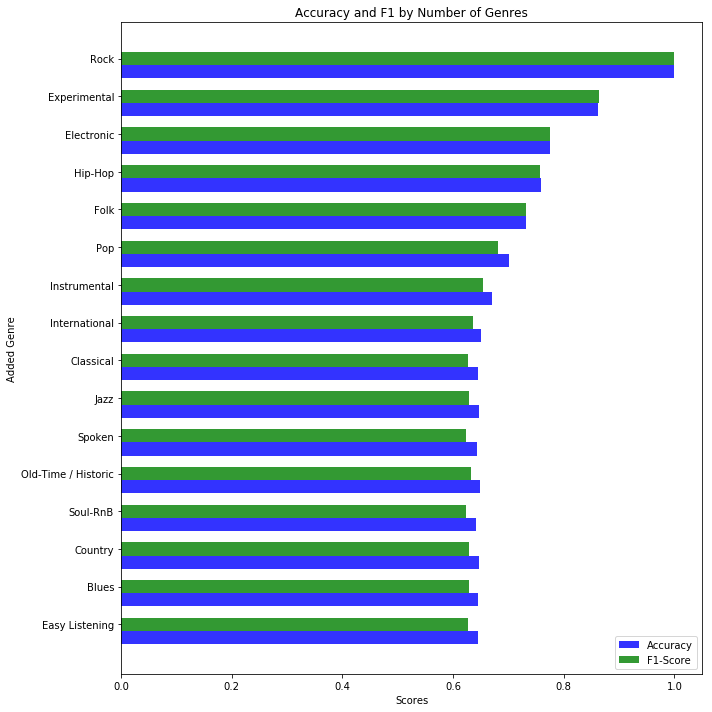

In [57]:
n_groups = 16

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.barh(index, acc[::-1], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Accuracy')
 
rects2 = plt.barh(index + bar_width, f1[::-1], bar_width,
                 alpha=opacity,
                 color='g',
                 label='F1-Score')
 
plt.ylabel('Added Genre')
plt.xlabel('Scores')
plt.title('Accuracy and F1 by Number of Genres')
plt.yticks(index + bar_width, keep_genres[::-1])
plt.legend()

plt.tight_layout()
plt.show()

## Part C: Various Multiclass Classifiers on 4 Genres

### Preprocessing

In [3]:
#df = pd.read_csv('df_final.csv')
df = df_final
df = df.dropna(axis = 0, how = 'any')
df=df[[col for col in df.columns.values if 'chroma' not in col]]

In [4]:
keep_genres = df.track_genre_top.value_counts()[0:4].index.values
df = df[df.track_genre_top.isin(keep_genres)]

In [5]:
X,y = df.iloc[:,5:],df.track_genre_top

Here, we split our data in two: we use two third of our data to train our model, one third will be used to test our model. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

### Attempt 1: K Nearest Neighbors

In [69]:
KNN = KNeighborsClassifier()

In [70]:
parameters = {"n_neighbors" : [3,6,10,15]}
clf = GridSearchCV(estimator=KNN, param_grid=parameters, scoring = 'accuracy', verbose = 2)
clf.fit(X_train2,y_train) 

In [ ]:
KNN = clf.best_estimator_
KNN.fit(X_train2,y_train)
y_pred = KNN.predict(X_test2)

In [ ]:
accuracy_score(y_test, y_pred)
f1_score(y_test,y_pred, average='weighted')

In [ ]:
KNN_pred = pd.crosstab(y_test, y_pred, rownames=['Actual Genres'], colnames=['Predicted Genres'])
KNN_pred

### Attempt 2: Random Forest

In [ ]:
RFC = RandomForestClassifier(class_weight = 'balanced')

In [ ]:
parameters = {"n_estimators" : [10,20,30,40], "max_depth" : [10,20,30,40]}
clf = GridSearchCV(estimator=RFC, param_grid=parameters, scoring = 'accuracy', verbose = 2)
clf.fit(X_train,y_train)

In [ ]:
RFC = clf.best_estimator_
RFC.fit(X_train,y_train)
y_pred = RFC.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)
f1_score(y_test,y_pred, average='weighted')

In [ ]:
RFC_pred = pd.crosstab(y_test, y_pred, rownames=['Actual Genres'], colnames=['Predicted Genres'])
RFC_pred

### Attempt 3: Gradient Boost

In [ ]:
GBC = GradientBoostingClassifier()

In [ ]:
parameters = {'min_samples_split': [80,100], 'min_samples_leaf': [20,40], 'max_depth': [5,8]}
clf = GridSearchCV(estimator=GBC, param_grid=parameters, scoring = 'accuracy', verbose = 1)
clf.fit(X_train,y_train)

In [ ]:
GBC = clf.best_estimator_
GBC.fit(X_train,y_train)
y_pred = GBC.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)
f1_score(y_test,y_pred, average='weighted')

In [ ]:
GBC_pred = pd.crosstab(y_test, y_pred, rownames=['Actual Genres'], colnames=['Predicted Genres'])
GBC_pred

### Attempt 4: Neural Networks

In [ ]:
MLP = MLPClassifier(alpha = .1, random_state=1)

In [ ]:
parameters = {'hidden_layer_sizes':[(3,),(5,),(15,),(3,3)]}
clf = GridSearchCV(estimator=MLP, param_grid=parameters, scoring = 'accuracy', verbose = 2)
clf.fit(X_train2,y_train)

In [ ]:
MLP = clf.best_estimator_
MLP.fit(X_train2,y_train)
y_pred = MLP.predict(X_test2)

In [ ]:
accuracy_score(y_test,y_pred)
f1_score(y_test,y_pred,average='weighted')

In [ ]:
MLP_pred = pd.crosstab(y_test, y_pred, rownames=['Actual Genres'], colnames=['Predicted Genres'])
MLP_pred

### Comparisons and Statistics

In [ ]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91,.3,.03,.4])

sns.heatmap(KNN_pred.apply(lambda r: r/r.sum(), axis=1),ax=ax0,cbar=True,vmin=0,vmax=1,cbar_ax = cbar_ax, cmap="YlGnBu")
ax0.set_title('KNN')
sns.heatmap(RFC_pred.apply(lambda r: r/r.sum(), axis=1),ax=ax1,cbar=True,vmin=0,vmax=1,cbar_ax = cbar_ax, cmap="YlGnBu")
ax1.set_title('RFC')
sns.heatmap(GBC_pred.apply(lambda r: r/r.sum(), axis=1),ax=ax2,cbar=True,vmin=0,vmax=1,cbar_ax = cbar_ax, cmap="YlGnBu")
ax2.set_title('GBC')
sns.heatmap(MLP_pred.apply(lambda r: r/r.sum(), axis=1),ax=ax2,cbar=True,vmin=0,vmax=1,cbar_ax = cbar_ax, cmap="YlGnBu")
ax2.set_title('MLP')

fig.suptitle('Classifier Comparison',fontsize=15)

plt.show()

Here we use our gradient boosting results to see which features are most important, but we could have used any algorithm for this.

In [ ]:
features = X_train.columns.values
importances = GBC.feature_importances_
indices = np.argsort(importances)[::-1][0:15]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

## Part D: MultiLabel Classification On More Genres

### Preprocessing

In [ ]:
df = df_final[pd.notnull(df_final['track_genres'])]

In [ ]:
track_genres = [ast.literal_eval(l) for l in list(df.track_genres)]
track_genres = [[genres[genres.genre_id==k].title.item() for k in el ] for el in track_genres ]

d={}
for l in track_genres:
    for genre in l:
        if genre in d:
            d[genre]+=1
        else:
            d[genre]=1

min_occurrence = 6000
d = {k: v for k, v in d.items() if v > min_occurrence}

In [ ]:
keys,values = [],[]

for k,v in d.items():
    keys.append(k)
    values.append(v)
    
keys,values = np.array(keys),np.array(values)

In [ ]:
indices = np.argsort(values)

plt.figure()
plt.title("Subgenres")
plt.barh(range(0,len(indices)), values[indices],
       color="r", align="center")
plt.yticks(range(0,len(indices)), keys[indices])
plt.ylim([-1, len(indices)])
plt.show()

In [ ]:
track_genres1 =[]

for l in track_genres:
    l1=[]
    for genre in l:
        if genre in d:
            l1.append(genre)
    track_genres1.append(l1)

In [ ]:
track_genres1 = [str(s) for s in track_genres1]
df.track_genres = track_genres1
df = df[.track_genres!='[]']

In [ ]:
def recall(y_test,y_pred):
    predicted = [0 for i in range(len(labels))]
    for i in range(len(labels)):
        l = y_pred[:,i]+y_test[:,i]
        predicted[i] = (l==2).sum()/float(y_test[:,i].sum())
    d={ 'Labels': labels, 'Recall': predicted }
    return pd.DataFrame(d, columns = ['Labels', 'Recall'])

In [ ]:
def precision(y_test,y_pred):
    actual = [0 for i in range(len(labels))]
    for i in range(len(labels)):
        l = y_pred[:,i]+y_test[:,i]
        actual[i] = (l==2).sum()/float(y_pred[:,i].sum())
    d={ 'Labels': labels, 'Precision': actual }
    return pd.DataFrame(d, columns = ['Labels', 'Precision'])

In [ ]:
df.track_genres = df.track_genres.apply(lambda x: ast.literal_eval(x))

In [9]:
X,y = df.iloc[:,5:],df.track_genres

In [10]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
labels = list(mlb.classes_)

['Avant-Garde',
 'Electronic',
 'Experimental',
 'Experimental Pop',
 'Folk',
 'Lo-Fi',
 'Noise',
 'Pop',
 'Rock']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
y_count = [0 for i in range(len(y[0,]))]

In [31]:
for i in range(len(y_count)):
    for j in range(len(y)):
        if sum(y[j])!=1:
            y_count[i]+=y[j,i]

In [ ]:
y_indices_largest = np.argsort(y_count)[::-1]
y_indices_smallest = np.argsort(y_count)

y_random = np.arange(len(y_count))
np.random.shuffle(y_random)

order_options = [y_random, y_indices_largest, y_indices_smallest]

### Attempt 1: KNN

#### One Vs The Rest

In [ ]:
KNN = OneVsRestClassifier(KNeighborsClassifier())

In [ ]:
parameters = {"estimator__n_neighbors" : [10,15,20]}
clf = GridSearchCV(estimator=KNN, param_grid=parameters, scoring = 'f1_weighted', verbose = 2)
clf.fit(X_train,y_train) 

In [ ]:
KNN = clf.best_estimator_
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)

In [ ]:
f1_KNN_OvsR = f1_score(y_test, y_pred,average='weighted')
Answer_KNN_OvsR = sum(sum(y_pred))/float(len(y_pred))

#### Classifier Chain

In [ ]:
f1_KNN_CC = 0
for order_option in order_options:
    KNNChain = ClassifierChain(KNN, order = order_option)
    KNNChain.fit(X_train, y_train)
    y_pred = KNNChain.predict(X_test)
    print(f1_score(y_test,y_pred, average = 'weighted'), jaccard_similarity_score(y_test,y_pred))
    f1_KNN_CC = max(f1_KNN_CC, f1_score(y_test,y_pred, average = 'weighted'))

In [ ]:
KNN_recall = recall(y_test,y_pred)
KNN_precision = precision(y_test,y_pred)
Answer_KNN_CC = sum(sum(y_pred))/float(len(y_pred))

### Attempt 2: Random Forest

#### One Vs the Rest

In [ ]:
RFC = OneVsRestClassifier(RandomForestClassifier())

In [ ]:
parameters = {"estimator__n_estimators" : [10,20,30,40], "estimator__max_depth" : [10,20,30,40]}
clf = GridSearchCV(estimator=RFC, param_grid=parameters, scoring = 'f1_weighted', verbose = 1)
clf.fit(X_train,y_train)

In [ ]:
RFC = clf.best_estimator_
RFC.fit(X_train,y_train)
y_pred = RFC.predict(X_test)

In [ ]:
f1_RF_OvsR = f1_score(y_test, y_pred,average='weighted')
Answer_RF_OvsR = sum(sum(y_pred))/float(len(y_pred))

#### Classifier Chain

In [ ]:
f1_RF_CC = 0
for order_option in order_options:
    RFCChain = ClassifierChain(RFC, order = order_option)
    RFCChain.fit(X_train, y_train)
    y_pred = RFCChain.predict(X_test)
    print(f1_score(y_test,y_pred, average = 'weighted'), jaccard_similarity_score(y_test,y_pred))
    f1_RF_CC = max(f1_RF_CC, f1_score(y_test,y_pred, average = 'weighted'))

In [ ]:
RFC_recall = recall(y_test,y_pred), 
RFC_precision = precision(y_test,y_pred)
Answer_RF_CC = sum(sum(y_pred))/float(len(y_pred))

### Attempt 3: Neural Networks

#### One Vs the Rest

In [ ]:
MLP = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15,), random_state=1)

In [ ]:
parameters = {'alpha': 10.0 ** -np.arange(1, 7)}
clf = GridSearchCV(estimator=MLP, param_grid=parameters, scoring = 'f1_weighted', verbose = 2)
clf.fit(X_train,y_train)

In [ ]:
clf = clf.best_estimator_
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
f1_NN_OvsR = f1_score(y_test, y_pred, average = 'weighted')
Answer_NN_OvR = sum(sum(y_pred))/float(len(y_pred))

#### Classifier Chain

In [ ]:
f1_NN_CC = 0
for order_option in order_options:
    MLPChain = ClassifierChain(clf, order = order_option)
    MLPChain.fit(X_train, y_train)
    y_pred = MLPChain.predict(X_test)
    print(f1_score(y_test,y_pred, average = 'weighted'), jaccard_similarity_score(y_test,y_pred))
    f1_NN_CC = max(f1_NN_CC, f1_score(y_test,y_pred, average = 'weighted'))

In [ ]:
NN_recall = recall(y_test,y_pred)
NN_precision = precision(y_test,y_pred)
Answer_NN_CC = sum(sum(y_pred))/float(len(y_pred))

### Comparisons

In [ ]:
methods = ['KNN_OneVsRest','KNN_Chain','RF_OneVsRest','RF_Chain','NN_OneVsRest','NN_Chain']
f1_score = [f1_KNN_OvsR, f1_KNN_CC, f1_RF_OvsR, f1_RF_CC, f1_NN_OvsR, f1_NN_CC]
scores={ 'F1_score': f1_score }
f1_score = pd.DataFrame(scores, index = methods, columns =  ['F1_score'])
f1_score

In [ ]:
recall = pd.merge(KNN_recall, RFC_recall, NN_recall, on='Labels')
recall.columns = ['Labels', 'KNN_recall' 'RFC_recall','NN_recall']
recall

In [ ]:
precision = pd.merge(KNN_precision, RFC_precision, NN_precision, on='Labels')
precision.columns = ['Labels', 'KNN_precision', 'RFC_precision','NN_precision']
precision

## Part E: Clustering on Track Titles

### Preprocessing

In [12]:
analysis_df=df_final[['track_id', 'track_title']]

In [13]:
def clean(text):
    stop = set(stopwords.words('english'))
#     stop.update(("Generic","words"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
#     porter= PorterStemmer()
    
    text=str(text).rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [14]:
text_clean=[]
for text in analysis_df['track_title']:
    text_clean.append(clean(text).split())

### Modelling

In [15]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [16]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=5, id2word = dictionary, passes=20)

In [17]:
top_words = ldamodel.print_topics(num_topics=5, num_words=20)

In [18]:
topics_df = []
for i in range(0,5):
    new_line = re.sub(r'[0-9]+', '',top_words[i][1])
    new_line = new_line.replace('*','')
    new_line = new_line.replace('"','')
    new_line = new_line.replace('.','')
    new_line = new_line.strip().split('+')
    topics_df.append(new_line)

In [19]:
prob_output=[]
for text in text_clean:
    prob_output.append(list(pd.DataFrame(ldamodel[dictionary.doc2bow(text)])[1]))

### Using Probabilities as Columns

In [ ]:
df_test= pd.DataFrame(prob_output, columns=["prob_cluster_1","prob_cluster_2","prob_cluster_3","prob_cluster_4","prob_cluster_5"])
df = pd.concat([df_final, df_test], axis=1)

df = df.dropna(axis = 0, how = 'any')

In [25]:
keep_genres = df.track_genre_top.value_counts()[0:4].index.values
df = df[df.track_genre_top.isin(keep_genres)]

X,y = df.iloc[:,5:],df.track_genre_top

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

In [29]:
MLP = MLPClassifier(alpha = .1, random_state=1)

In [30]:
parameters = {'hidden_layer_sizes':[(3,),(5,),(15,),(3,3)]}
clf = GridSearchCV(estimator=MLP, param_grid=parameters, scoring = 'accuracy', verbose = 2)
clf.fit(X_train2,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(3,) .........................................
[CV] .......................... hidden_layer_sizes=(3,), total=   2.3s
[CV] hidden_layer_sizes=(3,) .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] .......................... hidden_layer_sizes=(3,), total=   2.3s
[CV] hidden_layer_sizes=(3,) .........................................
[CV] .......................... hidden_layer_sizes=(3,), total=   3.4s
[CV] hidden_layer_sizes=(5,) .........................................
[CV] .......................... hidden_layer_sizes=(5,), total=   2.7s
[CV] hidden_layer_sizes=(5,) .........................................
[CV] .......................... hidden_layer_sizes=(5,), total=   2.2s
[CV] hidden_layer_sizes=(5,) .........................................
[CV] .......................... hidden_layer_sizes=(5,), total=   2.2s
[CV] hidden_layer_sizes=(15,) ........................................
[CV] ......................... hidden_layer_sizes=(15,), total=   2.4s
[CV] hidden_layer_sizes=(15,) ........................................
[CV] ......................... hidden_layer_sizes=(15,), total=   3.7s
[CV] hidden_layer_sizes=(15,) ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   35.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(3,), (5,), (15,), (3, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [31]:
MLP = clf.best_estimator_
MLP.fit(X_train2,y_train)
y_pred = MLP.predict(X_test2)

In [33]:
accuracy_score(y_test,y_pred)
f1_score(y_test,y_pred,average='weighted')

0.75911764705882356

## Part F: Taking in Mp3s

### Creating Features From File

In [55]:
def columns():
    feature_sizes = dict(tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()

In [56]:
def compute_features(track):
    
    #Largely based on FMA: A Dataset for music analysis. We wanted our calculated features data to look 
    #like the original dataset we used, for classification purposes.

    features = pd.Series(index=columns(), dtype=np.float32, name=track)

    # Catch warnings as exceptions (audioread leaks file descriptors).
    warnings.filterwarnings('error', module='librosa')

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    try:
        x, sr = librosa.load(track, sr=None, mono=True)  # kaiser_fast

        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
        feature_stats('zcr', f)

        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

        f = librosa.feature.tonnetz(chroma=f)
        feature_stats('tonnetz', f)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
        del x


        f = librosa.feature.rmse(S=stft)
        feature_stats('rmse', f)

        f = librosa.feature.spectral_centroid(S=stft)
        feature_stats('spectral_centroid', f)
        f = librosa.feature.spectral_bandwidth(S=stft)
        feature_stats('spectral_bandwidth', f)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
        feature_stats('spectral_contrast', f)
        f = librosa.feature.spectral_rolloff(S=stft)
        feature_stats('spectral_rolloff', f)

        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
        feature_stats('mfcc', f)

    except Exception as e:
        print('{}: {}'.format(track, repr(e)))

    return features


### Prediction Function

In [59]:
def GenrePredictor(track):
    features = compute_features(track)
    return MLP16.predict(features.values.reshape(1,-1))